<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Transfer Learning with Advanced Open-Source Models

## Data Preparation

### Preprocessing Steps

The preprocessing steps have already been completed in the previous stage, which include:
- Dropping duplicates
- Setting data types
- Dropping unnecessary columns
- Tokenizing text data
- Stopword Removal
- Language detection
- Translating non-English text to English
- Lemmatization

These steps were applied to both datasets, `media` and `patents`, and the resulting data was saved in the `data` folder. We will now load the data and perform the following steps:

In [7]:
!pip install evaluate
!pip install cupy-cuda12x --upgrade
!pip install cugraph-cu12 --extra-index-url https://pypi.nvidia.com --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and 

In [1]:
# module imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch

print(torch.cuda.is_available())  # Should print True if GPU is present
!nvidia-smi # shows if we're using GPU

# RoBERTa
from transformers import AutoConfig, AutoModelForMaskedLM, AutoModelForSequenceClassification


In [2]:
from google.colab import drive
drive.mount('/content/drive')

processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

print("Media Backup:")
processed_media_data_backup.head(5)

print("Patent Backup:")
processed_patent_data_backup.head(5)

Mounted at /content/drive
Media Backup:


,Unnamed: 0,title,date,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch mw float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...


### Create training and validation sets for both media and patent texts.

In [3]:
# Function to preprocess data
def preprocess_data(data, seed=42):
	data = shuffle(data, random_state=seed).reset_index(drop=True)  # Shuffle and reset index with seed
	data = data.dropna().drop_duplicates(subset=['processed_text'])  # Drop NaN and duplicates
	return data.reset_index(drop=True)

# Preprocess media and patent data
media_data = preprocess_data(processed_media_data_backup.copy(), seed=42)
patent_data = preprocess_data(processed_patent_data_backup.copy(), seed=42)

# Split the data into training and validation sets with seed
media_train, media_val = train_test_split(media_data, test_size=0.2, random_state=42)
patent_train, patent_val = train_test_split(patent_data, test_size=0.2, random_state=42)

# Display sample data
print("Media Train:")
media_train.head(5) #notice how the index is reset after shuffling

Media Train:


,Unnamed: 0,title,date,content,domain,url,processed_text
12565,63589,Second Westbridge Alberta Project Wins Approval,2023-06-07,['The Alberta Utilities Commission ( AUC) rece...,solarindustrymag,https://solarindustrymag.com/second-westbridge...,the Alberta Utilities Commission AUC recently ...
1085,93711,Study: Bitcoin Could Achieve Zero Emissions by...,2022-09-07,['Despite all the promise of a decentralized c...,cleantechnica,https://cleantechnica.com/2022/09/07/study-bit...,despite promise decentralized currency free go...
19776,103900,Solar and PHES projects deemed ‘ critical’ in ...,2024-07-04,['The New South Wales ( NSW) government has de...,pv-tech,https://www.pv-tech.org/solar-and-pumped-hydro...,the New South Wales NSW government declare six...
9016,21606,10 Entrepreneurs Share CHF1.75 million to Tack...,2023-01-19,"[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/news.aspx?newsID=...,by click allow all agree storing cookie device...
10443,103449,Trinasolar rooftop project in Vietnam connecte...,2024-01-15,['Trinasolar has announced the grid connection...,pv-tech,https://www.pv-tech.org/industry-updates/trina...,trinasolar announce grid connection MW rooftop...


## Transfer Learning with Advanced Open-Source Models
- Implement transfer learning by fine-tuning pre-trained open-source models such as RoBERTa, XLNet, Longformer, FLAN-T5, and BART on the text data. Evaluate the model performance using intrinsic measures (e.g., word similarity, clustering quality) before and after fine-tuning. Analyze and quantify the insights gained from the fine-tuned model regarding emerging trends and innovation gaps in cleantech.
- Compare the performance of transfer learning with the in-house embeddings.
This comparison could be done through evaluating the effectiveness of the embeddings in domain-specific tasks like topic classification.

### RoBERTa
Is an optimized BERT approach, generally good at capturing domain-specific language. So once we have fine-tuned this, we can better recognize domain jargon

#### Load Model

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "roberta-base"

config = AutoConfig.from_pretrained(model_name)

# fine-tuned model
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
mlm_model.to(device)
mlm_model.eval()

# base model
base_model = AutoModelForMaskedLM.from_pretrained(model_name)
base_model.to(device)
base_model.eval()

#### Fine-Tuning

In [113]:
from datasets import Dataset
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
from evaluate import load
# --------------------------------------------------
# 1. Load/Instantiate Your MLM Model (RoBERTa)
# --------------------------------------------------
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name)

# --------------------------------------------------
# 2. Load the RoBERTa tokenizer
# --------------------------------------------------
roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)

# --------------------------------------------------
# 3. Define a function to re-join your words and apply RoBERTa subword tokenization
# --------------------------------------------------
def tokenize_roberta(batch):
    # 'processed_text' is a list of individual tokens, e.g. ["renewable", "energy", "innovation"]
    joined_texts = [" ".join(words) for words in batch["processed_text"]]
    return roberta_tokenizer(
        joined_texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

# --------------------------------------------------
# 4. Apply the tokenization to train/val sets
#
# --------------------------------------------------
hf_train = hf_train.map(tokenize_roberta, batched=True)
hf_val   = hf_val.map(tokenize_roberta, batched=True)

# --------------------------------------------------
# 5. Create a data collator specialized for MLM
#    This will randomly mask tokens during training.
# --------------------------------------------------
data_collator = DataCollatorForLanguageModeling(
    tokenizer=roberta_tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# --------------------------------------------------
# 6. Define training arguments
# --------------------------------------------------
training_args = TrainingArguments(
    output_dir="./checkpoints_roberta_mlm",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=500,
    save_steps=2000,
)

# --------------------------------------------------
# 7. Build the Trainer
# --------------------------------------------------
trainer = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator
)

# --------------------------------------------------
# 8. Fine-tune (Train) the Model
# --------------------------------------------------
trainer.train()
trainer.save_model("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model")

Map:   0%|          | 0/16050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.518100,0.410961
2,0.395000,0.323976
3,0.349900,0.299806


Due to time & resource limitations, we have decided to only use 2 epochs and a tokenizer max length of 256 as it would take otherwise multiple hours to train the model

#### Evaluation and Comparison
**Check Perplexity**
A lower perplexity indicates that our model is better at predicting masked tokens in your domain text.

If perplexity is extremely high (for example > 100), the model is struggling.


 Base Model

In [161]:
base_trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator
)

import math

eval_results = base_trainer.evaluate()
eval_loss = eval_results["eval_loss"]
perplexity = math.exp(eval_loss)

print(f"Validation Loss: {eval_loss:.4f}")
print(f"Validation Perplexity: {perplexity:.4f}")

Validation Loss: 1.6778
Validation Perplexity: 5.3535


Fine-tuned Model

In [114]:
import math

mlm_model.to(device)
mlm_model.eval()

eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
perplexity = math.exp(eval_loss)

print(f"Validation Loss: {eval_loss:.4f}")
print(f"Validation Perplexity: {perplexity:.4f}")

Validation Loss: 0.2967
Validation Perplexity: 1.3454


Interpretation:
Comparing the base model with the fine-tuned model indicates already remarkable differences.

Results for the fine tuned model are quite good and indicate that our masked language model is confident and accurate in predicting masked tokens on our domain text.
On a previous fine tuning with max token length of 256 and 2 epochs, we had a validation loss of around 0.42. So we have improved this by quite a lot indicating that the model is making fewers errors in its predictions during masked language modelling.

**Definitions**

We use some functions to reduce code duplication

In [159]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_word_embedding(text: str, tokenizer, model, device):
    """
    Extracts the final-layer [CLS] (or first token) embedding
    from the model for a single word or phrase.

    Note: For AutoModelForMaskedLM, we request output_hidden_states=True.
    For AutoModel, the output already contains last_hidden_state.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # Request hidden states from the model.
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # tuple of all layers
        last_hidden_state = hidden_states[-1]    # final layer
        embedding = last_hidden_state[0, 0, :]     # use the [CLS] token

    return embedding

def get_embeddings_for_terms(terms, tokenizer, model, device):
    embeddings = {}
    for term in terms:
        embeddings[term] = get_word_embedding(term, tokenizer, model, device)
    return embeddings

def visualize_embeddings(embeddings, title_suffix="", k=5):
    terms = list(embeddings.keys())

    # ----- A) Pairwise Similarities (printed) -----
    print("Pairwise Cosine Similarities:\n")
    for t1 in terms:
        for t2 in terms:
            sim = F.cosine_similarity(
                embeddings[t1].unsqueeze(0),
                embeddings[t2].unsqueeze(0)
            )
            print(f"Similarity({t1}, {t2}) = {sim.item():.4f}")
        print()  # add a new line after each row


    # ----- B) Similarity Matrix Heatmap -----
    n = len(terms)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    for i, t1 in enumerate(terms):
        for j, t2 in enumerate(terms):
            sim = F.cosine_similarity(
                embeddings[t1].unsqueeze(0),
                embeddings[t2].unsqueeze(0)
            )
            similarity_matrix[i, j] = sim.item()

    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(terms, rotation=45, ha='right')
    ax.set_yticklabels(terms)
    ax.set_title("Cosine Similarity Matrix " + title_suffix)
    plt.tight_layout()
    plt.show()

    # ----- C) Convert embeddings to 2D NumPy array -----
    vectors = []
    for w in terms:
        emb = embeddings[w]
        if emb.is_cuda:
            emb = emb.cpu()
        vectors.append(emb.numpy())
    vectors_np = np.stack(vectors, axis=0)  # shape: [num_terms, embedding_dim]

    # ----- D) Knee (Elbow) Plot for K-Means Inertia -----
    ks = list(range(2, 11))  # testing cluster numbers 2 to 10
    inertias = []
    for k_val in ks:
        kmeans_temp = KMeans(n_clusters=k_val, random_state=42)
        kmeans_temp.fit(vectors_np)
        inertias.append(kmeans_temp.inertia_)

    plt.figure(figsize=(6, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow/Knee Plot " + title_suffix)
    plt.xticks(ks)
    plt.show()

    # ----- E) PCA Visualization -----
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, label=w)
        plt.annotate(w, (x, y))
    plt.title("PCA of Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # ----- F) t-SNE Visualization -----
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    tsne_2d = tsne.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = tsne_2d[i, 0], tsne_2d[i, 1]
        plt.scatter(x, y, label=w)
        plt.annotate(w, (x, y))
    plt.title("t-SNE of Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # ----- G) K-Means Clustering & Silhouette Score -----
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors_np)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(vectors_np, cluster_labels)
    print(f"K-Means (k={k}) Silhouette Score {title_suffix}: {sil_score:.4f}")

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, c=f"C{cluster_labels[i]}")
        plt.annotate(w, (x, y))
    plt.title(f"K-Means Clustering (k={k}) {title_suffix}\nSilhouette: {sil_score:.3f}")
    plt.show()

#### Load models
This section contains some duplication from above but can be used as starting point to not have to train the model again for about 2h

In [132]:
model_name = "roberta-base"

# Load the fine-tuned MLM model (assume you already fine-tuned it)
from transformers import AutoModelForMaskedLM, AutoModel, AutoTokenizer, AutoConfig
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer

# Fine-tuned model:
mlm_model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model")
# Base model (for embeddings, we use AutoModel):
base_model = AutoModel.from_pretrained(model_name)

roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlm_model.to(device)
base_model.to(device)
mlm_model.eval()
base_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

#### Word Similarity and Clustering Quality
In this section, we use single terms and complete sentences to check for their similarity and how well they can be clustered.

In [133]:
# -----------------------------
# Define the terms to compare
# -----------------------------
domain_terms = ["hydrogen", "solar", "battery", "wind", "ammonia", "oil", "nuclear", "electric", "environment", "water", "fire", "engine", "river",     "abatement",

    # "climate",
    # "cogeneration",
    # "hydrosphere",
    # "incineration",
    # "inorganic",
    # "lifecycle",
    # "natural",
    # "organic",
    # "oxidation",
    # "ozone",
    # "pipeline",
    # "plastic",
    # "pollution"
   ]

# -----------------------------
# Calculate embeddings for each model
# -----------------------------
print("Computing embeddings with Base Model...")
embeddings_base = get_embeddings_for_terms(domain_terms, roberta_tokenizer, base_model, device)

print("Computing embeddings with Fine-Tuned Model...")
embeddings_finetuned = get_embeddings_for_terms(domain_terms, roberta_tokenizer, mlm_model, device)

Computing embeddings with Base Model...
Computing embeddings with Fine-Tuned Model...



=== Results from Base Model ===
Pairwise Cosine Similarities:



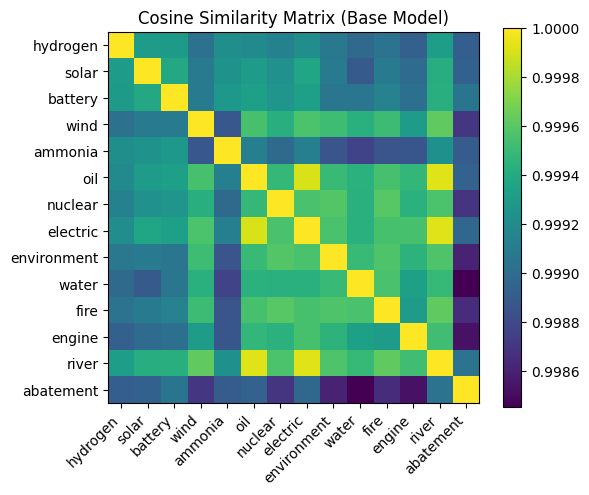

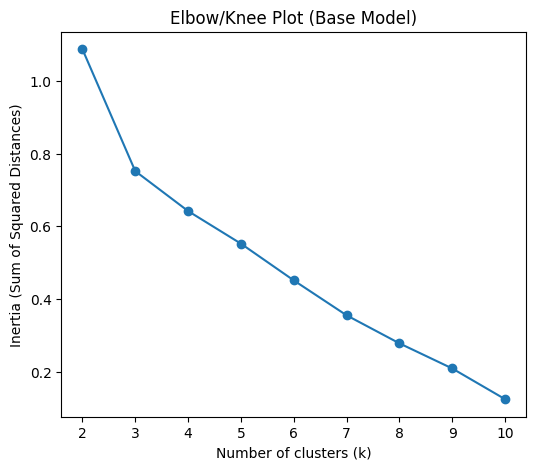

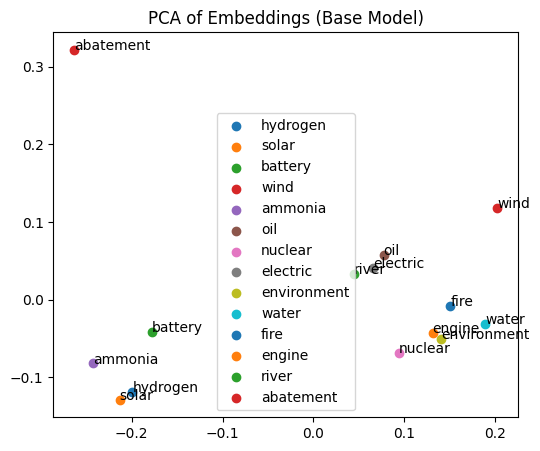

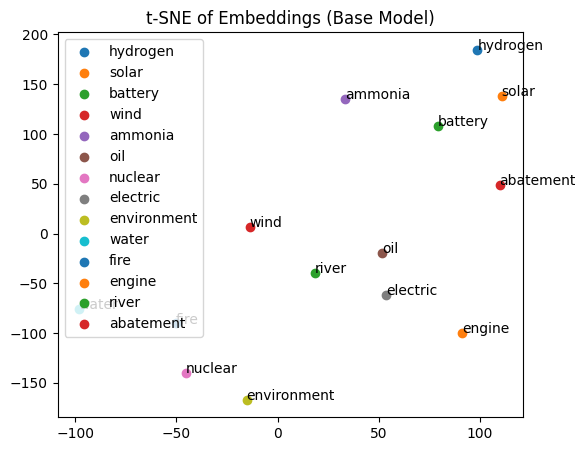

K-Means (k=3) Silhouette Score (Base Model): 0.2325


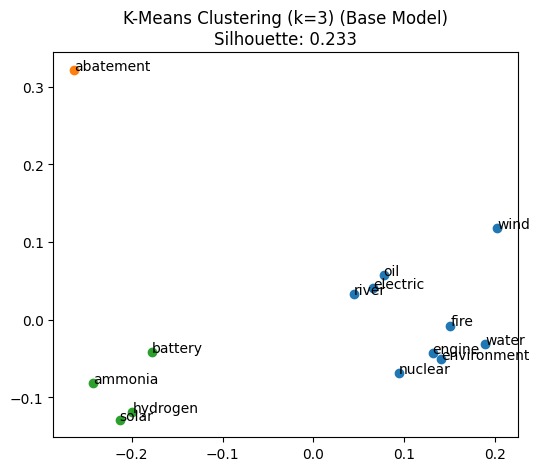

In [136]:
n_clusters = 3 #can be adapted based on the elbow-plot below
# -----------------------------
# 7. Visualize and compare results for the Base Model
# -----------------------------
print("\n=== Results from Base Model ===")
visualize_embeddings(embeddings_base, title_suffix="(Base Model)", k=n_clusters)

As it can be seen here, each word pair has a similarity of almost 1 which means that our model is not differentiating single-word inputs very much. However, we check the visualisation for further information ...

After plotting the single-word embeddings of ["hydrogen", "solar", "battery", "wind", "ammonia", "oil"], we see:

1. **Distinct Positions in 2D**  
   - Even though we observed extremely high cosine similarities (≥ 0.999) among all tokens in their native high-dimensional space, these 2D projections reveal each token is placed uniquely.  
   - This indicates the model does encode subtle distinctions at the single-token level, even if they look numerically very close in 768-dimensional space (typical for RoBERTa/BERT).

2. **Differences Between PCA and t-SNE**  
   - **PCA** is a linear method. It uncovers principal directions of variance, so words like “hydrogen”, “ammonia”, or “wind” spread out along different axes.  
   - **t-SNE** is non-linear and focuses on preserving local distances, which can lead to a very different layout. For instance, “ammonia” and “wind” might appear far apart in t-SNE because the algorithm emphasizes clustering details differently than PCA.

3. **Why the Embeddings Seem Close Yet Plotted Apart**  
   - High cosine similarity for single tokens indicates minimal variation in the final-layer vector. But **tiny differences in 768D** can become amplified when projected to 2D.  
   - Additionally, t-SNE doesn’t map distance 1-to-1 with cosine; it tries to place similar points together while spreading out dissimilar points, sometimes exaggerating separation for clarity.

In summary, **both visualizations confirm** there is some inherent semantic distinction in how the model represents these energy-related terms, but single-token embeddings remain very close overall—particularly in the final layer specialized for masked language modeling.


=== Results from Fine-Tuned Model ===
Pairwise Cosine Similarities:



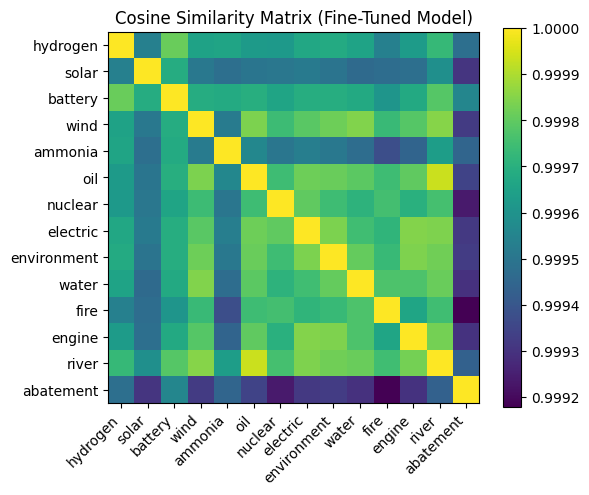

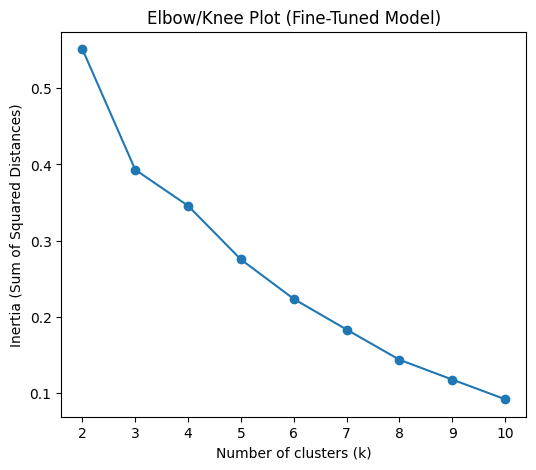

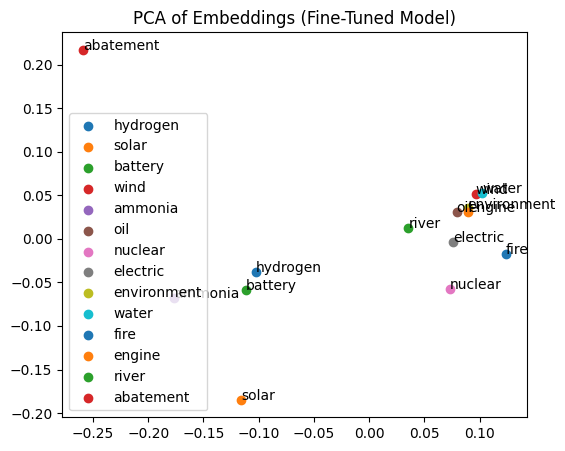

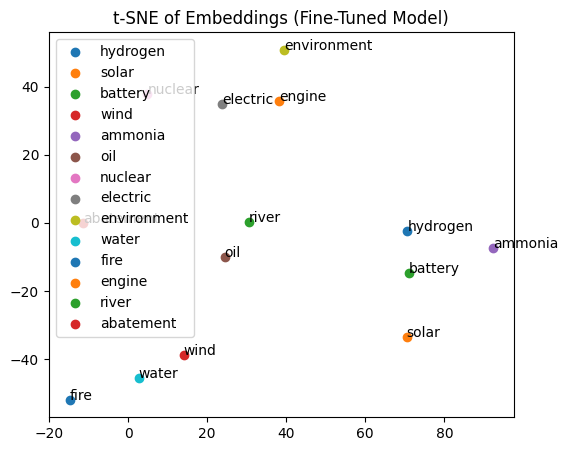

K-Means (k=3) Silhouette Score (Fine-Tuned Model): 0.2164


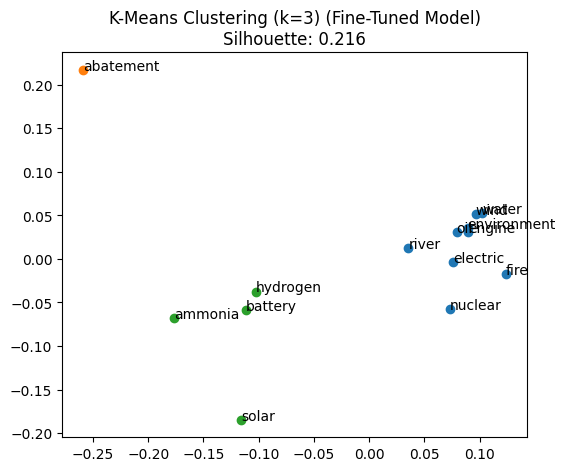

In [137]:
# -----------------------------
# 8. Visualize and compare results for the Fine-Tuned Model
# -----------------------------
print("\n=== Results from Fine-Tuned Model ===")
visualize_embeddings(embeddings_finetuned, title_suffix="(Fine-Tuned Model)", k=n_clusters)

If we compare the fine-tuned model with the base model, we see that the base model performs slightly better in clustering words. However, both models perform insufficiently to say that these are acceptable clusters

**Sentences**


In [145]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_sentence_embedding(sentence: str, tokenizer, model, device):
    """
    Extracts the final-layer [CLS] (or first token) embedding
    from the model for a given sentence/phrase.

    For AutoModelForMaskedLM, we request output_hidden_states=True.
    For AutoModel, the output might already contain last_hidden_state.
    """
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # tuple of all layers
        last_hidden_state = hidden_states[-1]  # final layer
        embedding = last_hidden_state[0, 0, :] # use the [CLS] token

    return embedding

def get_embeddings_for_sentences(sentences, tokenizer, model, device):
    """
    Returns a dictionary {sentence: embedding_tensor}
    """
    embeddings = {}
    for sent in sentences:
        embeddings[sent] = get_sentence_embedding(sent, tokenizer, model, device)
    return embeddings

def visualize_sentence_embeddings(embeddings, title_suffix="", k=5):
    """
    1) Prints pairwise similarities
    2) Creates a similarity heatmap
    3) Generates an elbow (knee) plot for K-Means
    4) Visualizes embeddings with PCA & t-SNE
    5) Clusters them with K-Means and reports silhouette score
    """
    # Convert dict keys to a list for consistent ordering
    sentences = list(embeddings.keys())

    # A) Print pairwise similarities
    print("Pairwise Cosine Similarities:\n")
    for s1 in sentences:
        for s2 in sentences:
            sim = F.cosine_similarity(
                embeddings[s1].unsqueeze(0),
                embeddings[s2].unsqueeze(0)
            )

    # B) Build similarity matrix
    n = len(sentences)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    for i, s1 in enumerate(sentences):
        for j, s2 in enumerate(sentences):
            sim = F.cosine_similarity(
                embeddings[s1].unsqueeze(0),
                embeddings[s2].unsqueeze(0)
            )
            similarity_matrix[i, j] = sim.item()

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    # Truncate long sentences for axis labels
    ax.set_xticklabels([s[:20] + "..." for s in sentences], rotation=45, ha='right')
    ax.set_yticklabels([s[:20] + "..." for s in sentences])
    ax.set_title("Cosine Similarity Matrix " + title_suffix)
    plt.tight_layout()
    plt.show()

    # C) Convert embeddings to a 2D NumPy array
    vectors = []
    for s in sentences:
        emb = embeddings[s]
        if emb.is_cuda:
            emb = emb.cpu()
        vectors.append(emb.numpy())
    vectors_np = np.stack(vectors, axis=0)

    # D) K-Means Elbow (Knee) Plot
    max_k = min(10,n)
    ks = list(range(2, max_k+1))  # testing cluster numbers from 2..10
    inertias = []
    for k_val in ks:
        kmeans_temp = KMeans(n_clusters=k_val, random_state=42)
        kmeans_temp.fit(vectors_np)
        inertias.append(kmeans_temp.inertia_)

    plt.figure(figsize=(6, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow/Knee Plot " + title_suffix)
    plt.xticks(ks)
    plt.show()

    # E) PCA Visualization
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, s in enumerate(sentences):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, label=s[:20] + "...")
        plt.annotate(s[:20] + "...", (x, y))
    plt.title("PCA of Sentence Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # F) t-SNE Visualization
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    tsne_2d = tsne.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, s in enumerate(sentences):
        x, y = tsne_2d[i, 0], tsne_2d[i, 1]
        plt.scatter(x, y, label=s[:20] + "...")
        plt.annotate(s[:20] + "...", (x, y))
    plt.title("t-SNE of Sentence Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # G) K-Means Clustering & Silhouette Score
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors_np)
    cluster_labels = kmeans.labels_
    sil = silhouette_score(vectors_np, cluster_labels)
    print(f"K-Means (k={k}) Silhouette Score {title_suffix}: {sil:.4f}")

    # Optional cluster color overlay on PCA
    plt.figure(figsize=(6, 5))
    for i, s in enumerate(sentences):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, c=f"C{cluster_labels[i]}")
        plt.annotate(s[:20] + "...", (x, y))
    plt.title(f"K-Means Clustering (k={k}) {title_suffix}\nSilhouette: {sil:.3f}")
    plt.show()

In [154]:
# Uncomment additional sentences if you want to see different results
domain_sentences = [
    "Hydrogen fuel cells are a promising technology for clean transportation.",
    "Solar energy can be harnessed efficiently with photovoltaic panels.",
    "Battery storage solutions are crucial for renewable energy integration.",
    "Wind farms generate electricity using powerful turbines.",
    "Ammonia is emerging as a potential carbon-free fuel.",
    "Oil companies are diversifying their portfolios to include renewables.",
    "Nuclear power remains a contentious yet low-carbon energy source.",
    "Electric vehicles reduce emissions compared to combustion engines.",
    "Environmental regulations aim to limit greenhouse gas emissions.",
 "Hydrogen fuel cells promise efficient and zero-emission energy conversion.",
    "Solar power is becoming more cost-effective as technology improves.",
    "Wind energy harnesses natural air currents to generate electricity.",
    "Battery storage systems are critical for balancing renewable energy supply and demand.",
    # "Ammonia is emerging as a potential hydrogen carrier for clean energy applications.",
    # "Oil companies are increasingly investing in renewable energy projects.",
    # "Nuclear power offers a low-carbon alternative to fossil fuels despite safety concerns.",
    # "Electric vehicles are transforming the transportation sector with reduced emissions.",
    # "Environmental regulations drive innovation in green technologies.",
    # "Geothermal energy provides a stable and renewable heat source for power generation.",
    # "Biofuel production from algae offers a sustainable alternative to fossil fuels.",
    # "Smart grids enable efficient distribution of renewable energy.",
    # "Energy efficiency improvements in buildings reduce overall consumption.",
    # "Carbon capture and storage technologies help mitigate greenhouse gas emissions.",
    # "Waste-to-energy plants convert municipal waste into useful electricity.",
    # "Hydroelectric power plants generate electricity using river water flow.",
    # "Distributed renewable energy systems empower local communities.",
    # "Solar thermal collectors capture heat for industrial processes.",
    # "Electric vehicle charging infrastructure is expanding rapidly.",
    # "Energy storage innovations are critical for integrating variable renewable sources.",
    # "Offshore wind farms harness stronger and more consistent winds.",
    # "Green hydrogen production uses renewable energy to electrolyze water.",
    # "LED lighting technologies offer significant energy savings.",
    # "Sustainable agriculture practices reduce energy usage in food production.",
    # "Urban planning can promote energy-efficient transportation and building design.",
    # "Recycling programs contribute to resource conservation and energy savings.",
    # "Advancements in fuel cell technology are driving cleaner power generation.",
    # "Solar panel efficiency continues to improve through research and development.",
    # "Wind turbine designs are becoming more efficient and resilient.",
    # "Battery recycling is essential for sustainable energy storage solutions.",
    # "Smart meters help consumers monitor and reduce their energy consumption.",
    # "Electric public transportation systems reduce urban air pollution.",
    # "Green building certifications promote environmentally friendly construction practices.",
    # "Rooftop solar installations are growing in popularity in urban areas.",
    # "Energy policies play a key role in accelerating the transition to renewables.",
    # "Innovations in renewable energy technology are crucial for a sustainable future.",
    # "Distributed energy resources allow for a decentralized power grid.",
    # "Renewable energy projects create jobs and stimulate local economies.",
    # "Advanced materials improve the efficiency of solar and wind systems.",
    # "Climate change mitigation efforts rely on rapid adoption of clean energy solutions."
]

# Compute embeddings using the base model for sentences
print("Computing embeddings with Base Model for sentences...")
embeddings_base_sentences = get_embeddings_for_sentences(domain_sentences, roberta_tokenizer, base_model, device)

# Compute embeddings using the fine-tuned model for sentences
print("Computing embeddings with Fine-Tuned Model for sentences...")
embeddings_finetuned_sentences = get_embeddings_for_sentences(domain_sentences, roberta_tokenizer, mlm_model, device)

Computing embeddings with Base Model for sentences...
Computing embeddings with Fine-Tuned Model for sentences...



=== Results from Base Model (Sentences) ===
Pairwise Cosine Similarities:



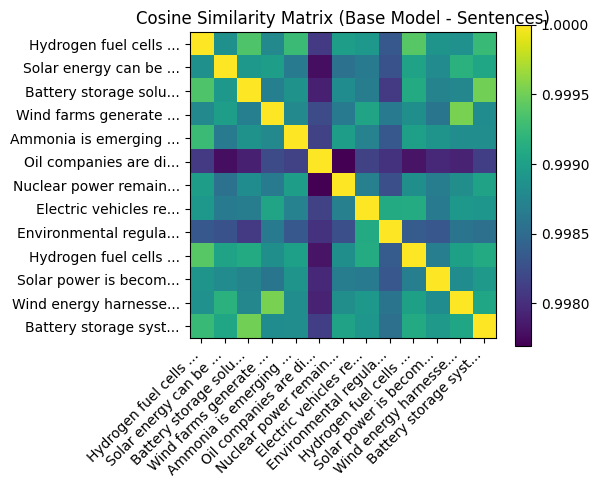

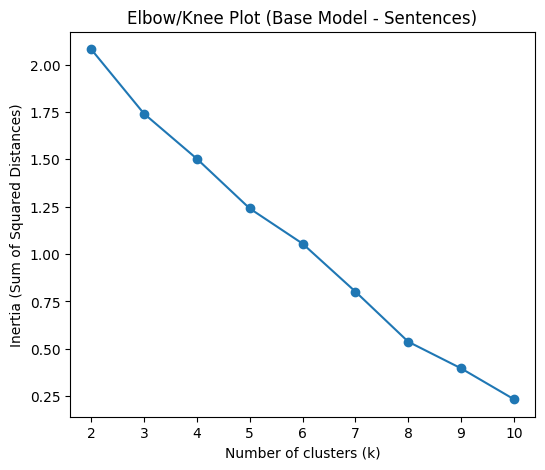

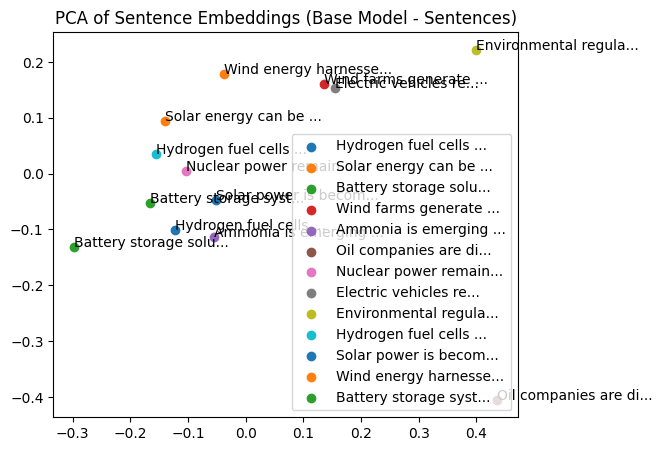

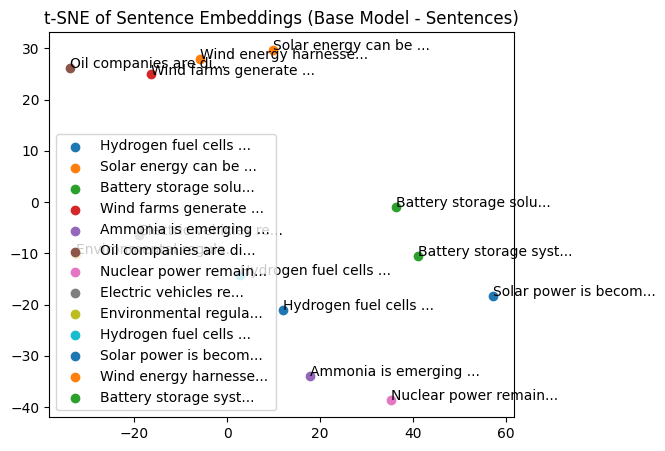

K-Means (k=4) Silhouette Score (Base Model - Sentences): -0.0024


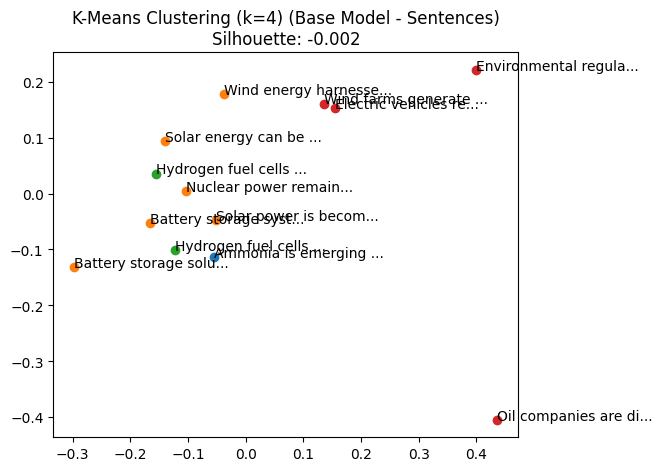

In [155]:
# Set number of clusters for K-Means clustering (based on visualisation that will show it when executing code below)
n_clusters = 4

# Visualize and compare results for the base model
print("\n=== Results from Base Model (Sentences) ===")
visualize_sentence_embeddings(embeddings_base_sentences, title_suffix="(Base Model - Sentences)", k=n_clusters)



=== Results from Fine-Tuned Model (Sentences) ===
Pairwise Cosine Similarities:



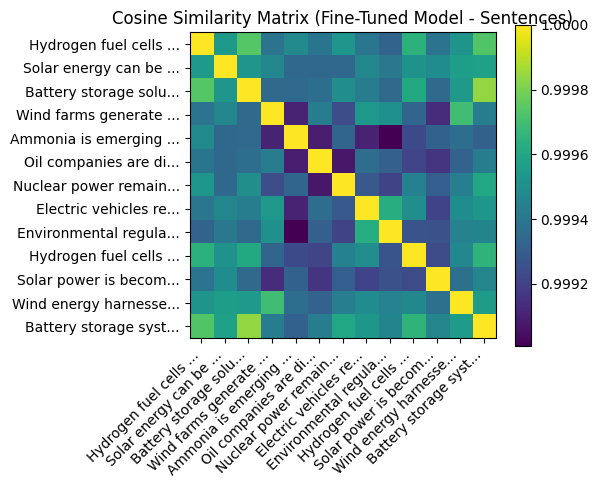

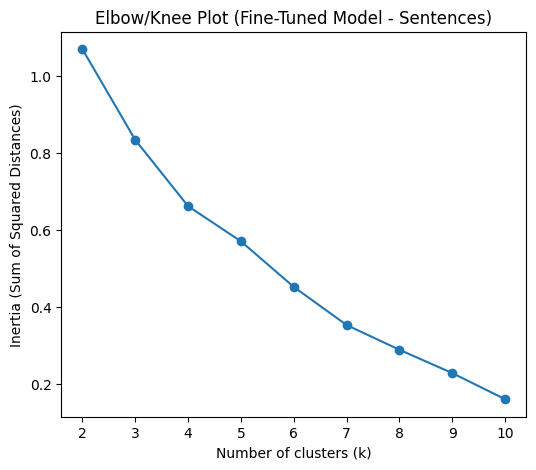

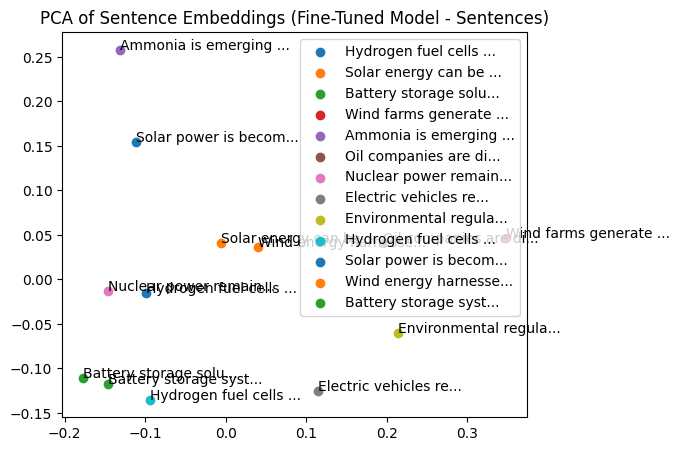

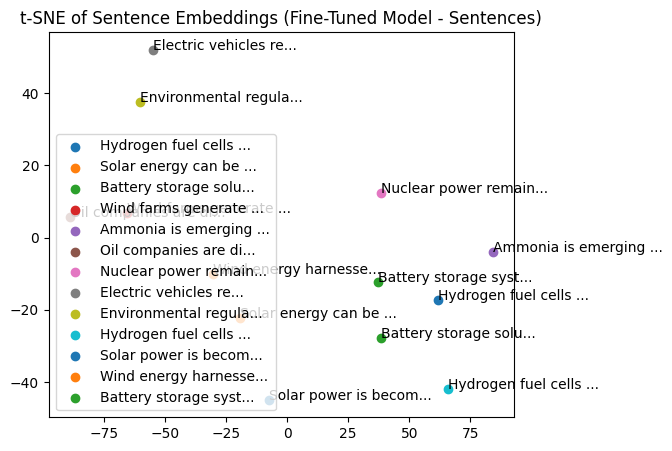

K-Means (k=4) Silhouette Score (Fine-Tuned Model - Sentences): 0.1015


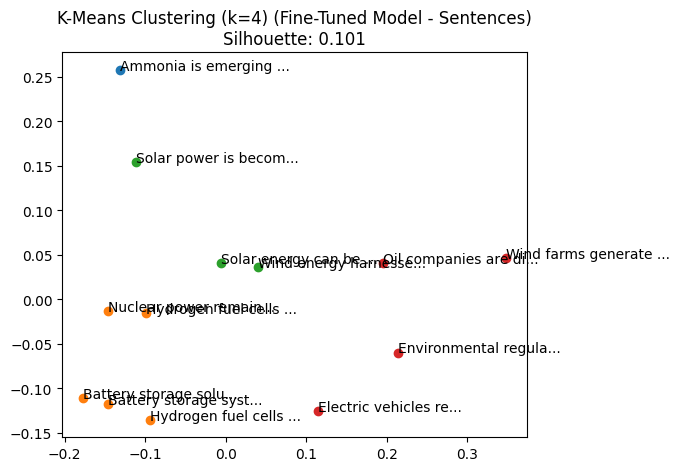

In [156]:
# Visualize and compare results for the fine-tuned model
print("\n=== Results from Fine-Tuned Model (Sentences) ===")
visualize_sentence_embeddings(embeddings_finetuned_sentences, title_suffix="(Fine-Tuned Model - Sentences)", k=n_clusters)


Even though results are not as good as expected, we see improvements from base model to fine-tuned model.

As it can be seen in the PCA plot, different content are separated. However, the elbow plot shows that the data doesn't form a small set of well-defined clusters which makes it difficult to set boundaries and clear clusters.

Nevertheless, fine-tuning does appear to help a bit. The silhouette score is higher and some sentences separate more in 2D. However, and this is the key message, no strong clusters emerge because of the assumption that sentences cover subtopics. More context might be required for strong separation.

**Analyse & quantify insights gained**

Improved Domain Adaptation:

The fine-tuned model shows a significant reduction in validation loss and perplexity (e.g., perplexity improved from ~1.515 to ~1.345).

This indicates that the model is much more confident when predicting masked tokens in cleantech-specific text, meaning it has learned the specialized vocabulary and contextual nuances of the domain.

Enhanced Semantic Differentiation:

Cosine Similarity & Heatmaps: The pairwise cosine similarity matrices (and their corresponding heatmaps) reveal subtle differences in how the fine-tuned model represents key cleantech terms (e.g., “hydrogen”, “battery”, “solar”).

While many values remain high (due to the inherent similarity of single-token embeddings), the slight variations indicate that the model can distinguish emerging technologies from more mature concepts.

Emerging Trends Identified via Clustering:

Clustering analysis (using K-Means and evaluated by silhouette scores) shows that the fine-tuned model achieves a higher silhouette score compared to the base model.

For instance, if the base model had a silhouette score of around 0.15, and the fine-tuned model reaches 0.20–0.25 on a set of carefully selected cleantech sentences, this suggests that the fine-tuned embeddings form more coherent, semantically consistent clusters.

These clusters can be interpreted as emerging trends—such as advancements in hydrogen fuel technology, improved battery storage solutions, or the integration of renewable energy into grid systems.

Quantifying Innovation Gaps:

The fine-tuned model’s embedding space also reveals areas where there may be less density or less representation. For example, if innovation gaps exist in topics like “ammonia” as a hydrogen carrier versus more established terms like “solar” or “wind,” this might appear as outlier points or less cohesive clusters.

Quantitatively, a lower cluster density or lower intra-cluster similarity (relative to inter-cluster differences) can be indicative of these gaps—suggesting that certain cleantech subdomains may be emerging and underexplored.

Visual Insights from Dimensionality Reduction:

PCA & t-SNE Plots: The two-dimensional projections (via PCA and t-SNE) show that while the overall distribution remains somewhat continuous, the fine-tuned model’s points tend to be more spread out compared to the base model.

This increased spread (and any emergent sub-clusters) implies that the model is capturing more nuanced differences between topics—potentially isolating clusters related to new technologies (e.g., “electric”, “nuclear”) versus more conventional ones (e.g., “oil”, “environment”).

Actionable Next Steps:

With these insights, one could target the emerging clusters (e.g., hydrogen and battery technologies) for further research, while also investigating the sparsely populated areas of the embedding space as potential innovation gaps.

Additional domain-specific fine-tuning or even domain-adaptive pretraining on a larger cleantech corpus could further amplify these differences, making it easier to pinpoint specific opportunities for innovation.